## Dependency analysis

This notebook contains analysis of dependencies in Common Criteria certificates.

### Interesting occurences I have noticed during analysing data
- 3970 certificates referencing no other certificates: directly_affecting == Nan && indirectly_affecting == NaN
- 158 certificates which are affected by at least one certificates and affecting no certificates.
- 311 certificates are affected by at least one archived certicates.
- 16 BSI certificates affecting ANSSI certificates out of total 831 BSI certs.
- 38 ANSSI certificates affecting BSI certificates out of total 682 ANSSI certs.
- 25 certificates are crossed referenced
- Certificates with security level EAL6+ are directly affecting other certificates with levels: {'EAL6+': 38, 'EAL5+': 6, 'EAL4+': 5} (EAL6+ is directly affecting certificates with lower security levels)
- Most common security level among smart-cards is EAL5+ with 671 occurences.
- Highest Smart Card BSI level: EAL6+, most common level: EAL4+
- Highest Smart Card ANSSI level: EAL7, most common level: EAL5+
- Lowest security level among smart cards in dataset: EAL1+ ['ATMEL AT90SC6464C Integrated circuit (reference AT568A9 rev. F)',
 'CT2000 embedded Component (reference ST16RFHD50/RSG-A)',
 'M/Chip Select v2.0.5.2 Application',
 'MODEUS electronic purse : MODEUS carrier card v1.1 (reference : ST16RF58/RSE+) and SAM TC/C v1.1 retailer security module (reference : ST19SF16FF/RVN)',
 "Oberthur B0' application v1.0.1 and GemClub v1.3 loaded on Javacard/VOP GemXpresso platform 211 V2",
 'Palmera Protect platform V2.0 JavaCard (SLE66CX320P/SB62 embedded component)',
 'VOP 2.0.1 / Javacard 2.1.1 JPH33V2 Operating system version 1 installed on Integrated circuit PHILIPS P8WE5033',
 'Javacard/VOP GemXpresso 211 platform (Philips Integrated circuit P8WE5032/MPH02)',
 'Javacard/VOP GemXpresso 211 platform V2 (Philips P8WE5032/MPH04 embedded component, A000000018434D Card Manager)',
 'S3C8975 for smart cards Integrated circuit',
 "'Mondex Purse 2' electronic purse version 0203 component SLE66CX160S, MULTOS V4.1N operating system)",
 "B4/B0' V2 bank application of the MONEO/CB hybrid card (reference : ST19SF16B RCL version B303/B002)",
 "Javacard/VOP GemXpresso 211 platform (Philips P8WE5032/MPH02 Integrated circuit ) with Oberthur B0' v0.32 and Visa VSDC v1.08 applets",
 'MONEO electronic wallet card carrier (ST19SF16B RCL v. B303) and PSAM retailer security module (ST19SF16B RCL v. C103)']


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections 
import datetime

from sec_certs.dataset.common_criteria import CCDataset
from typing import Tuple, List

plt.style.use("ggplot")

In [3]:
dset: CCDataset = CCDataset.from_json("/home/george/Downloads/dependency_json_final2.json")
dset._compute_dependencies()
df = dset.to_pandas()

print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset has 4616 rows and 20 columns.


In [4]:
df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting
dgst,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.dreamsecurity.com/,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:hotfix1:*:...,NaN,NaN,NaN,NaN,NaN,NaN
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4616 entries, a89ee15539d006d1 to 09b17cb9b3c8b1bb
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cert_id                 3252 non-null   object        
 1   name                    4616 non-null   object        
 2   status                  4616 non-null   category      
 3   category                4616 non-null   category      
 4   manufacturer            4615 non-null   object        
 5   scheme                  4616 non-null   category      
 6   security_level          4616 non-null   object        
 7   not_valid_before        4616 non-null   datetime64[ns]
 8   not_valid_after         4327 non-null   datetime64[ns]
 9   report_link             4616 non-null   object        
 10  st_link                 4616 non-null   object        
 11  manufacturer_web        4554 non-null   object        
 12  extracted_versions      46

In [6]:
df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting
dgst,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.dreamsecurity.com/,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:hotfix1:*:...,NaN,NaN,NaN,NaN,NaN,NaN
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filter top 10 manufacturers and see which categories are the most common

In [7]:
MANUFACTURER_COUNT = 10
top_manufacturers_list = df[df["manufacturer"].notna()]["manufacturer"].value_counts().head(MANUFACTURER_COUNT).index.tolist()
top_manufacturers_df = df[df["manufacturer"].isin(top_manufacturers_list)]
top_manufacturers_df["category"].value_counts()

ICs, Smart Cards and Smart Card-Related Devices and Systems    445
Multi-Function Devices                                         164
Other Devices and Systems                                      108
Network and Network-Related Devices and Systems                 96
Operating Systems                                               75
Trusted Computing                                               44
Databases                                                       30
Data Protection                                                 25
Mobility                                                        23
Boundary Protection Devices and Systems                         19
Access Control Devices and Systems                              13
Detection Devices and Systems                                    5
Key Management Systems                                           4
Products for Digital Signatures                                  3
Biometric Systems and Devices                                 

### How many archived certificates are in dataset?

In [8]:
archived_df = df[df["status"] == "archived"]
print(f"There are total {archived_df.shape[0]} archived certificates.")

There are total 3057 archived certificates.


### How many active certificates are in dataset?

In [9]:
active_df = df[df["status"] == "active"]
print(f"There are total {active_df.shape[0]} active certificates.")

There are total 1559 active certificates.


Text(0.5, 1.0, 'Archived certs vs. active certs')

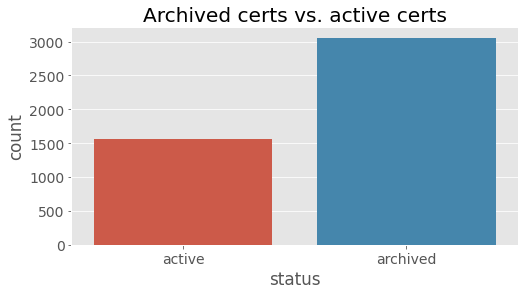

In [10]:
plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 14})
sns.countplot(x=df["status"]).set_title("Archived certs vs. active certs")

### Which certificates are referenced at least by one certificate? 

In [11]:
def is_directly_affected_by(references):
    if references is np.nan:
        return False
    
    return True

def count_directly_affected_by(references):
    if references is np.nan:
        return np.nan
    return len(references)

directly_affected_by_df = df.copy()
directly_affected_by_df["is_directly_affected_by"] = df["directly_affected_by"].apply(is_directly_affected_by)
directly_affected_by_df["directly_affected_by_sum"] = directly_affected_by_df["directly_affected_by"].apply(count_directly_affected_by)
directly_affected_by_df.sort_values(by="directly_affected_by_sum", ascending=False, inplace=True)
directly_affected_by_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_directly_affected_by,directly_affected_by_sum
dgst,,,,,,,,,,,,,,,,,,,,,
f041e5b526e79ef4,BSI-DSZ-CC-0410-2007,"NXP Secure Smart Card Controller P5CD080V0B, P...",archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"[ALC_DVS.2, AVA_MSU.3, AVA_VLA.4, EAL5+]",2007-07-05,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,[-],NaN,NaN,NaN,"[BSI-DSZ-CC-0798-2012, BSI-DSZ-CC-0797-2012, B...","{BSI-DSZ-CC-0532-2008, BSI-DSZ-CC-0446-2007, B...",{BSI-DSZ-CC-0404-2007},{BSI-DSZ-CC-0404-2007},True,33.0
9dab3f1341f54c42,BSI-DSZ-CC-0555-2009,NXP Smart Card Controller P5CD081V1A and its m...,archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors,DE,[EAL5+],2009-11-10,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,[-],NaN,NaN,NaN,"[BSI-DSZ-CC-0784-2013, BSI-DSZ-CC-0857-2013, B...","{ANSSI-CC-2012/30, BSI-DSZ-CC-0675-2011, BSI-D...",NaN,NaN,True,19.0
dbbf02a1cd0ad33b,ANSSI-CC-2010/02,STMicroelectronics SA23YR48/80B and SB23YR48/8...,archived,"ICs, Smart Cards and Smart Card-Related Device...",STMicroelectronics,FR,"[ALC_FLR.1, EAL6+]",2010-02-10,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,"[3.0, 2.0]",NaN,NaN,NaN,"[BSI-DSZ-CC-0877-2013, ANSSI-CC-2010/34, BSI-D...","{ANSSI-CC-2010/22, ANSSI-CC-2010/57, ANSSI-CC-...",NaN,NaN,True,19.0
7d4585a4b5b6e873,ANSSI-CC-2010/02,Ucard UBJ31-G11 V1.1,archived,"ICs, Smart Cards and Smart Card-Related Device...",UBIVELOX,KR,"[ALC_DVS.2, AVA_VAN.5, EAL4+]",2012-10-31,2019-06-01,https://www.commoncriteriaportal.org/files/epf...,...,[1.1],NaN,NaN,NaN,"[BSI-DSZ-CC-0877-2013, ANSSI-CC-2010/34, BSI-D...","{ANSSI-CC-2010/22, ANSSI-CC-2010/57, ANSSI-CC-...",NaN,NaN,True,19.0
f2c2231b0ffae4d7,BSI-DSZ-CC-0978-2016,NXP Secure Smart Card Controller P60x144/080yV...,archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"[ALC_FLR.1, ASE_TSS.2, EAL6+]",2016-02-05,2021-02-05,https://www.commoncriteriaportal.org/files/epf...,...,[-],NaN,NaN,NaN,"[BSI-DSZ-CC-0978-V2-2017, BSI-DSZ-CC-0957-V2-2...","{ANSSI-CC-2016/41, ANSSI-CC-2016/26, BSI-DSZ-C...",NaN,NaN,True,18.0


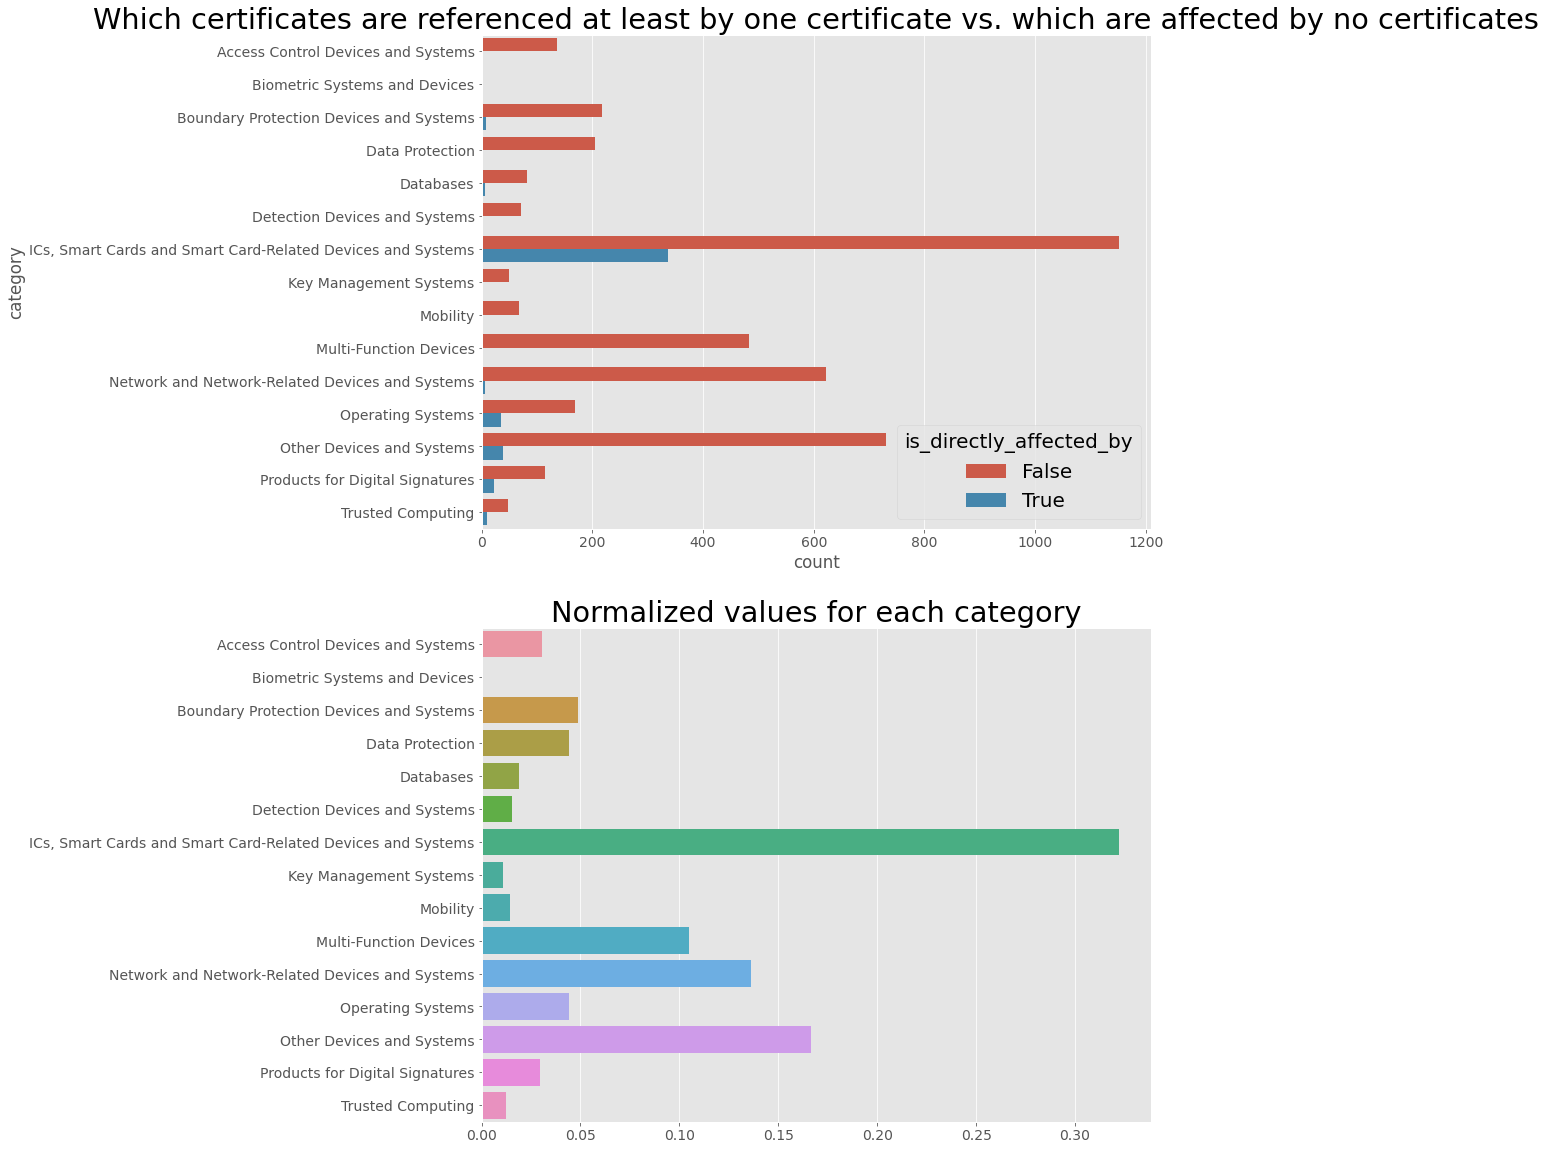

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,20))
normalized_serie = directly_affected_by_df["category"].value_counts(normalize=True)
plt.rcParams.update({'font.size': 20})
sns.countplot(y="category", hue="is_directly_affected_by", data=directly_affected_by_df, ax=ax1).set_title("Which certificates are referenced at least by one certificate vs. which are affected by no certificates")
sns.barplot(y=normalized_serie.index, x=normalized_serie.values, ax=ax2).set_title("Normalized values for each category")
plt.show()

### Which certificates are referencing no other?

In [12]:
no_affecting_df = df[df["directly_affecting"].isna() & df["indirectly_affecting"].isna()]

print(f"There are total {no_affecting_df.shape[0]} certificates referencing no other certificates.")

There are total 3970 certificates referencing no other certificates.


In [13]:
no_affecting_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting
dgst,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.dreamsecurity.com/,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:hotfix1:*:...,NaN,NaN,NaN,NaN,NaN,NaN
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN


### How many no affecting certificates are affected by other certificates?

In [14]:
affected_but_no_affecting_df = no_affecting_df[no_affecting_df["directly_affected_by"].notna() & no_affecting_df["indirectly_affected_by"].notna()]
print(f"There are total of {affected_but_no_affecting_df.shape[0]} certificates which are affected by other certificates and affecting no certificates.")

There are total of 158 certificates which are affected by other certificates and affecting no certificates.


### How many certificates are not affected by other certificates, nor affecting other certificates?

In [15]:
def is_no_affecting_nor_affected(directly_affecting, indirectly_affecting, directly_affected_by, indirectly_affected_by):
    if directly_affecting is np.nan and indirectly_affecting is np.nan and directly_affected_by is np.nan and indirectly_affected_by is np.nan:
        return True
    
    return False


no_affecting_no_affected_df = df.copy()
no_affecting_no_affected_df["is_no_affecting_nor_affected"] = df.apply(lambda x: is_no_affecting_nor_affected(x["directly_affecting"], x["indirectly_affecting"], x["directly_affected_by"], x["indirectly_affected_by"]), axis=1)
no_affecting_no_affected_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_no_affecting_nor_affected
dgst,,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,...,https://www.dreamsecurity.com/,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,...,https://www.netiq.com/,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:hotfix1:*:...,NaN,NaN,NaN,NaN,NaN,NaN,True
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


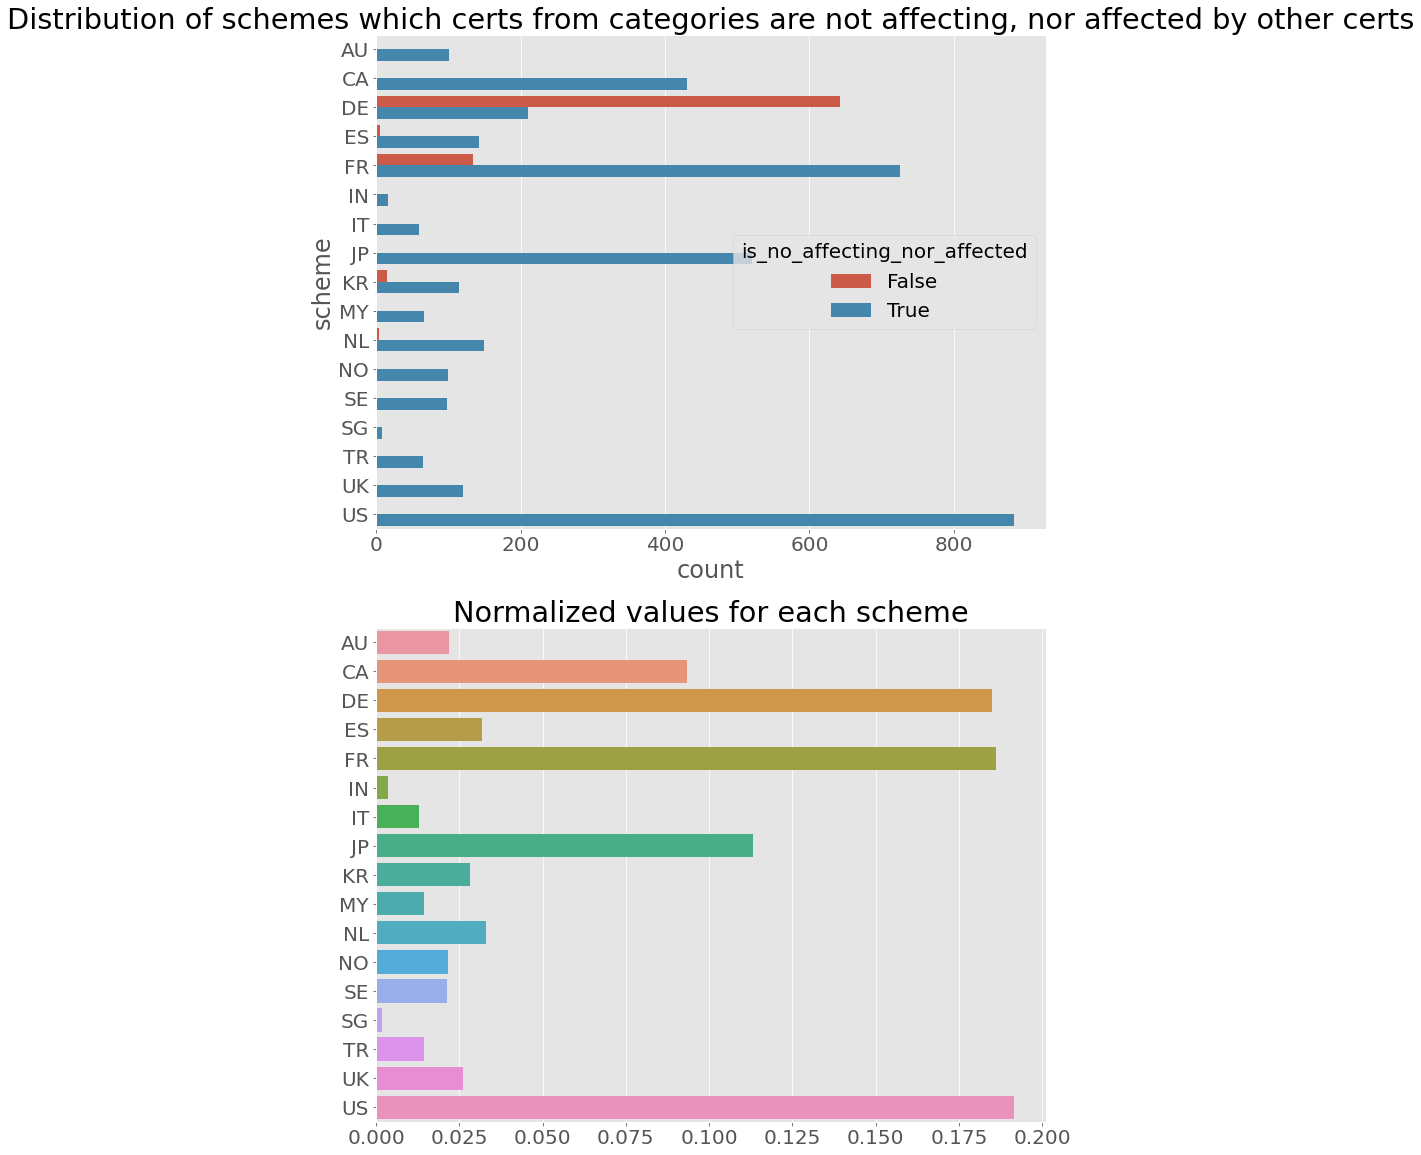

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,20))
normalized_serie = no_affecting_no_affected_df["scheme"].value_counts(normalize=True)
plt.rcParams.update({'font.size': 20})
sns.countplot(y="scheme", hue="is_no_affecting_nor_affected", data=no_affecting_no_affected_df, ax=ax1).set_title("Distribution of schemes which certs from categories are not affecting, nor affected by other certs")
sns.barplot(y=normalized_serie.index, x=normalized_serie.values, ax=ax2).set_title("Normalized values for each scheme")
plt.show()

### Which certificates are dependent on the archived certificates?

In [16]:
archived_cert_id_list = df[df["cert_id"].notna() & (df["status"] == "archived")]["cert_id"].tolist()

def contains_archived_cert_dependency(affected_by):
    if affected_by is np.nan:
        return False
    
    for cert_id in affected_by:
        if cert_id in archived_cert_id_list:
            return True
        
    return False


depends_on_archived_df = df.copy()
depends_on_archived_df["depends_on_archived"] = depends_on_archived_df["directly_affected_by"].apply(contains_archived_cert_dependency)
total_records_dependent = sum(depends_on_archived_df["depends_on_archived"])
print(f"Total {total_records_dependent} certificates are affected by at least one archived certicates.")

Total 311 certificates are affected by at least one archived certicates.


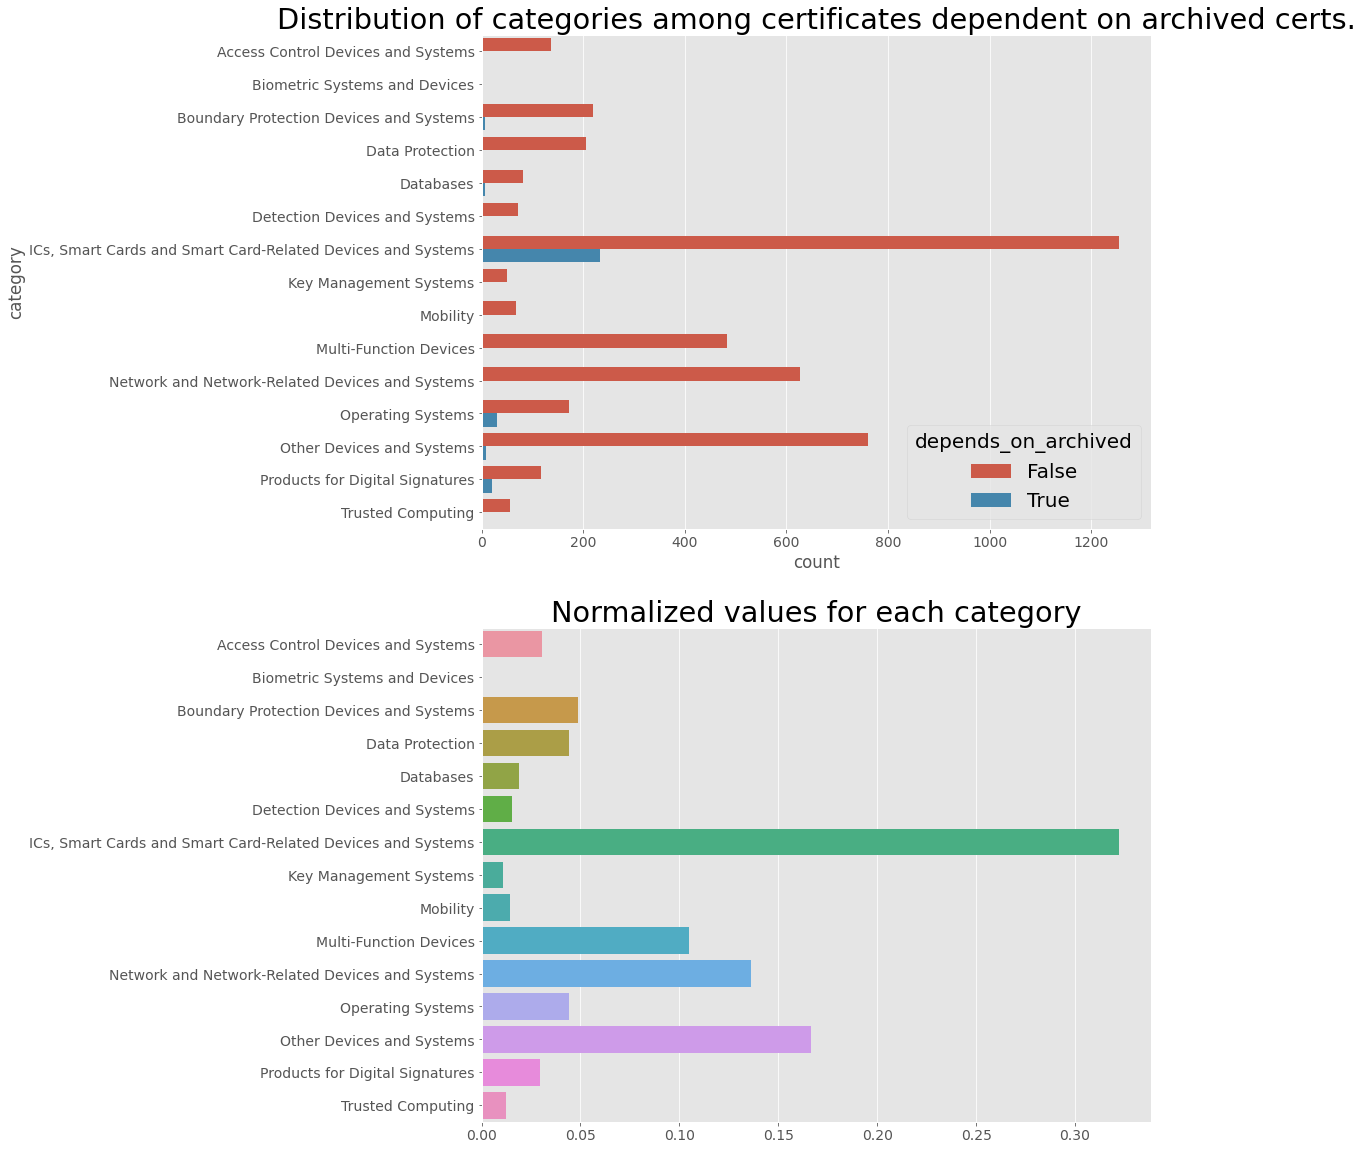

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,20))
normalized_serie = depends_on_archived_df["category"].value_counts(normalize=True)
plt.rcParams.update({'font.size': 20})
sns.countplot(y="category", hue="depends_on_archived", data=depends_on_archived_df, ax=ax1).set_title("Distribution of categories among certificates dependent on archived certs.")
sns.barplot(y=normalized_serie.index, x=normalized_serie.values, ax=ax2).set_title("Normalized values for each category")
plt.show()

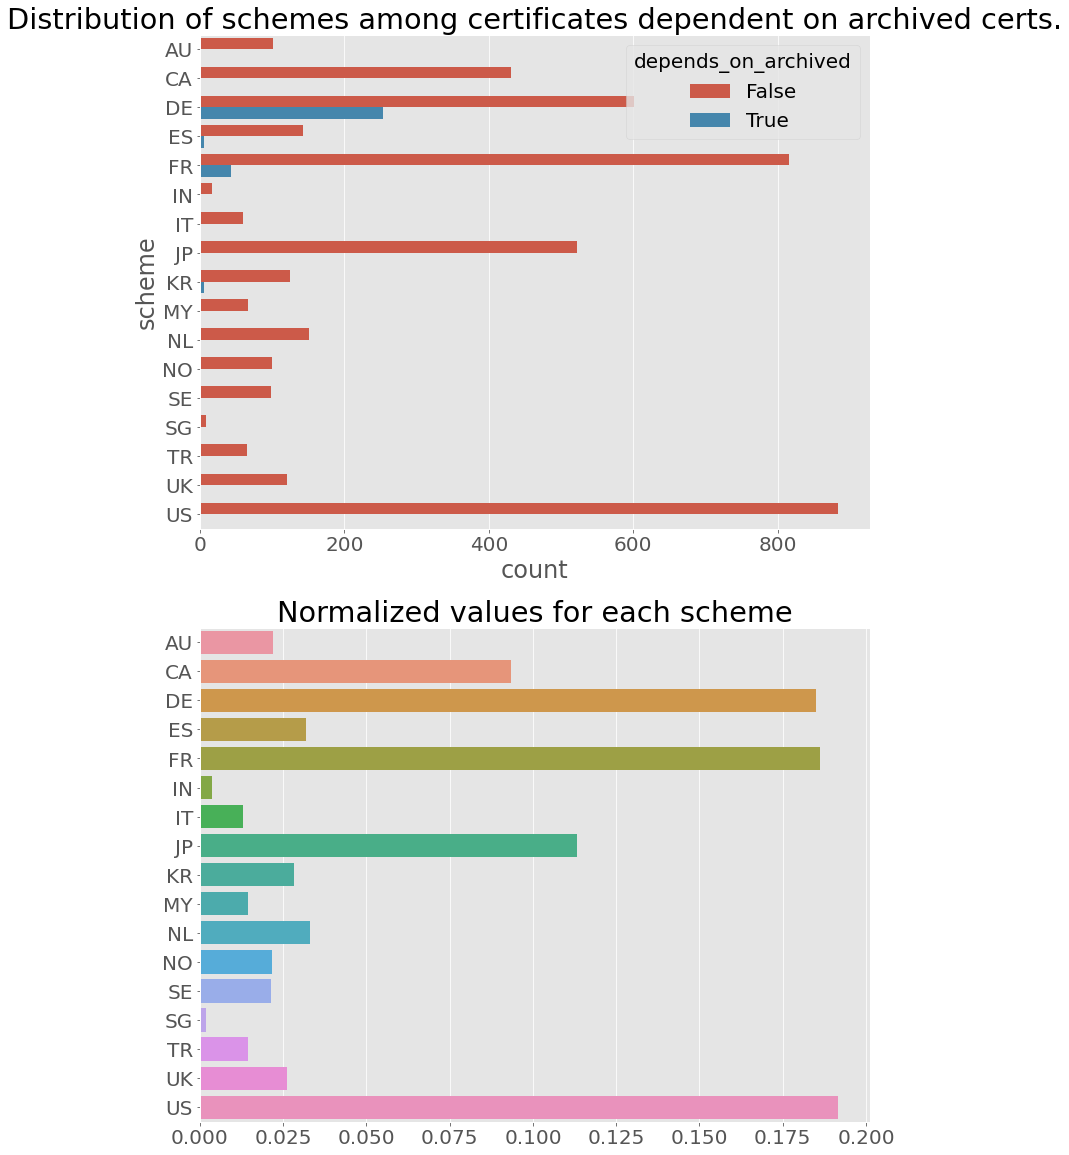

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,20))
normalized_serie = depends_on_archived_df["scheme"].value_counts(normalize=True)
plt.rcParams.update({'font.size': 20})
sns.countplot(y="scheme", hue="depends_on_archived", data=depends_on_archived_df, ax=ax1).set_title("Distribution of schemes among certificates dependent on archived certs.")
sns.barplot(y=normalized_serie.index, x=normalized_serie.values, ax=ax2).set_title("Normalized values for each scheme")
plt.show()

### How frequently are BSI certificates referencing ANSSI certs and vice versa?

In [18]:
from typing import Set


def is_bsi_cert(cert_id: str) -> bool:
    if cert_id is np.nan:
        return False
    
    if cert_id.lower().startswith("bsi"):
        return True
    
    return False


def is_anssi_cert(cert_id: str) -> bool:
    if cert_id is np.nan:
        return False
    
    if cert_id.lower().startswith("anssi"):
        return True

    return False


def is_affecting_anssi(directly_affecting: Set[str]) -> bool:
    if directly_affecting is np.nan:
        return False
    
    for cert_id in directly_affecting:
        if is_anssi_cert(cert_id):
            return True
        
    return False


def is_affecting_bsi(directly_affecting: Set[str]) -> bool:
    if directly_affecting is np.nan:
        return False
    
    for cert_id in directly_affecting:
        if is_bsi_cert(cert_id):
            return True
    
    return False
    
    
df["is_bsi_cert"] = df["cert_id"].apply(is_bsi_cert)
df["is_anssi_cert"] = df["cert_id"].apply(is_anssi_cert)

bsi_df = df[df["is_bsi_cert"] == True].copy()
anssi_df = df[df["is_anssi_cert"] == True].copy()

bsi_df["is_affecting_anssi"] = bsi_df["directly_affecting"].apply(is_affecting_anssi)
bsi_affecting_anssi_df = bsi_df[bsi_df["is_affecting_anssi"] == True]

anssi_df["is_affecting_bsi"] = anssi_df["directly_affecting"].apply(is_affecting_bsi)
anssi_affecting_bsi_df = anssi_df[anssi_df["is_affecting_bsi"] == True]

bsi_total_records = bsi_df.shape[0]
anssi_total_records = anssi_df.shape[0]
bsi_affecting_records = bsi_affecting_anssi_df.shape[0]
anssi_affecting_records = anssi_affecting_bsi_df.shape[0]

print(f"There are {bsi_affecting_records} BSI certs affecting ANSSI certs out of total {bsi_total_records} BSI certs.")
print(f"There are {anssi_affecting_records} ANSSI certs affecting BSI certs out of total {anssi_total_records} ANSSI certs.")

print(f"Success hit for BSI certs: {bsi_affecting_records / bsi_total_records}")
print(f"Success hit for ANSSI certs: {anssi_affecting_records / anssi_total_records}")

There are 16 BSI certs affecting ANSSI certs out of total 831 BSI certs.
There are 38 ANSSI certs affecting BSI certs out of total 682 ANSSI certs.
Success hit for BSI certs: 0.019253910950661854
Success hit for ANSSI certs: 0.05571847507331378


In [22]:
bsi_affecting_anssi_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,is_affecting_anssi
dgst,,,,,,,,,,,,,,,,,,,,,
424f6d496746258b,BSI-DSZ-CC-1064-2020,MTCOS Pro 2.5 EAC with PACE / ST31G480 D01,active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, AVA_VAN.5, EAL5+]",2020-09-29,2025-09-29,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,[BSI-DSZ-CC-1065-2020],{BSI-DSZ-CC-1065-2020},"{ANSSI-CC-2019/12, BSI-DSZ-CC-0995-2018}","{BSI-DSZ-CC-0973-2016, ANSSI-CC-2019/12, BSI-D...",True,False,True
b8437dbfeeaf0f04,BSI-DSZ-CC-1065-2020,MTCOS Pro 2.5 EAC with PACE / ST31G480 D01 (BAC),active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, EAL4+]",2020-09-29,2025-09-29,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{ANSSI-CC-2019/12, BSI-DSZ-CC-1064-2020}","{BSI-DSZ-CC-0973-2016, ANSSI-CC-2019/12, BSI-D...",True,False,True
4832a44c0df0bad2,BSI-DSZ-CC-1074-V2-2020,Xaica-Alpha PLUS ePassport on MTCOS Pro 2.5 wi...,active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, EAL4+]",2020-07-30,2025-07-30,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1074-V2, ANSSI-CC-2019/12, BSI-DSZ...","{BSI-DSZ-CC-1073-V2, ANSSI-CC-2019/12, BSI-DSZ...",True,False,True
7f9eb1b8217d15ad,BSI-DSZ-CC-1073-V2-2020,Xaica-Alpha PLUS ePassport on MTCOS Pro 2.5 wi...,active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, AVA_VAN.5, EAL4+]",2020-07-30,2025-07-30,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1074-V2, ANSSI-CC-2019/12, BSI-DSZ...","{BSI-DSZ-CC-1073-V2, ANSSI-CC-2019/12, BSI-DSZ...",True,False,True
06e505abb8dad1b8,BSI-DSZ-CC-1003-2018,Smart Meter Gateway Security Module Applicatio...,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto,DE,"[AVA_VAN.5, EAL4]",2018-09-18,2028-09-18,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{ANSSI-CC-2017/54, BSI-DSZ-CC-0891-V2-2016}","{ANSSI-CC-2017/54, BSI-DSZ-CC-0891-2015, BSI-D...",True,False,True


### Which certificates are referencing each other? (= are crossed referenced)

In [19]:
def is_already_involved(cross_reference_list: List[Tuple[str, str]], certs_set: Set[str]) -> bool:
    return certs_set in cross_reference_list

def is_cert_affecting_other_cert(root_cert_id: str, affected_cert_id: str) -> bool:
    return affected_cert_id in cross_df[cross_df["cert_id"] == root_cert_id].iloc[0]["directly_affecting"]

cross_reference_list: List[Set[str]] = []
cross_df = df[(df["cert_id"].notna()) & (df["directly_affecting"].notna())]
count = 1
total = cross_df.shape[0]

for cert_record in cross_df.itertuples():
    cert_id = cert_record.cert_id

    for another_cert_record in cross_df.itertuples():

        another_cert_id = another_cert_record.cert_id
        
        if cert_record.cert_id == another_cert_record.cert_id:
            continue
            
        certs_set = set([cert_id, another_cert_id])
        
        if is_cert_affecting_other_cert(cert_id, another_cert_id) and is_cert_affecting_other_cert(another_cert_id, cert_id) and not is_already_involved(cross_reference_list, certs_set):
            cross_reference_list.append(certs_set)
    count += 1 
    
    
print(f"Total of {len(cross_reference_list)} crossed referenced certificates.")
print(cross_reference_list)


KeyboardInterrupt



### What are the EAL levels typically affecting a certificate? E.g. are certificates referencing EAL5 typically higher or same level?

In [20]:
df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert
dgst,,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,...,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,...,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,...,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,...,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:hotfix1:*:...,NaN,NaN,NaN,NaN,NaN,NaN,False,False
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,...,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [21]:
# Introduce security level EAL variable
eals = ['EAL1', 'EAL1+', 'EAL2', 'EAL2+', 'EAL3', 'EAL3+', 'EAL4', 'EAL4+', 'EAL5', 'EAL5+', 'EAL6+', 'EAL7', 'EAL7+']
df['highest_security_level'] = df.security_level.map(lambda all_levels: [eal for eal in all_levels if eal.startswith('EAL')] if all_levels else np.nan)
df.highest_security_level = df.highest_security_level.map(lambda x: x[0] if x and isinstance(x, list) else np.nan)
df.highest_security_level = pd.Categorical(df.highest_security_level, categories=eals, ordered=True)

In [22]:
levels_df = df[(df["highest_security_level"].notna()) & (df["directly_affecting"].notna()) & (df["cert_id"].notna())].copy()
levels_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
98c1ac41aedcdae2,BSI-DSZ-CC-1142-2020,genuscreen 7.0,active,Boundary Protection Devices and Systems,genua GmbH,DE,"[ALC_FLR.2, ASE_TSS.2, AVA_VAN.4, EAL4+]",2020-08-18,2025-08-17,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-1085-2019},{BSI-DSZ-CC-1085-2019},True,False,EAL4+
0eff4063e68d7cd6,BSI-DSZ-CC-0823-2014,genuscreen 4.0,active,Boundary Protection Devices and Systems,GeNUA mbH,DE,"[ALC_FLR.2, ASE_TSS.2, AVA_VAN.4, EAL4+]",2014-10-29,NaT,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,[BSI-DSZ-CC-0966-2015],{BSI-DSZ-CC-0966-2015},{BSI-DSZ-CC-0565-2009},"{BSI-DSZ-CC-0565-2009, BSI-DSZ-CC-0382-2007}",True,False,EAL4+
e62f50581d828477,BSI-DSZ-CC-0519-V3-2021,ORGA 6141 online Version 3.7.2:1.2.0,active,"ICs, Smart Cards and Smart Card-Related Device...",Ingenico Healthcare GmbH,DE,"[ADV_FSP.4, ADV_IMP.1, ADV_TDS.3, ALC_TAT.1, A...",2021-03-22,2026-03-22,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-0519-V2-2018},{BSI-DSZ-CC-0519-V2-2018},True,False,EAL3+
6a5cb89e80f86ce9,BSI-DSZ-CC-0977-V3-2021,NXP Secure Smart Card Controller N7021 VA incl...,active,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH,DE,"[ALC_FLR.1, ASE_TSS.2, EAL6+]",2021-02-24,2026-02-24,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-0977-V2-2019, BSI-DSZ-CC-0977-V3}","{BSI-DSZ-CC-0977-V2-2019, BSI-DSZ-CC-0977-2017...",True,False,EAL6+
41fb9717f70d3037,BSI-DSZ-CC-1052-V3-2021,RISE Konnektor V3.0,active,"ICs, Smart Cards and Smart Card-Related Device...",Research Industrial Systems Engineering (RISE)...,DE,"[ADV_FSP.4, ADV_INT.1, ADV_TDS.3, ALC_FLR.2, A...",2021-02-22,2026-03-21,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1052-V2-2020, BSI-DSZ-CC-1052-V3}","{BSI-DSZ-CC-1052-V2-2020, BSI-DSZ-CC-1052-2018...",True,False,EAL3+


In [23]:
from typing import Dict

def get_cert_id_security_level(cert_id: str) -> str:
    cert_id_df = df[df["cert_id"] == cert_id]
    
    if cert_id_df.empty:  # we do not have record in main dset for this cert_id
        return None
    
    return cert_id_df.iloc[0]["highest_security_level"]


def get_levels_of_affected_certs(affected_certs: Set[str]) -> Dict[str, int]:
    result = {}
    
    for affected_cert_id in affected_certs:
        security_level = get_cert_id_security_level(affected_cert_id)
        
        if security_level is None:  # cert_id does not follow condition for levels_df
            continue
            
        result[security_level] = result.get(security_level, 0) + 1
        
    return result
        

levels_df["affecting_security_levels"] = levels_df["directly_affecting"].apply(get_levels_of_affected_certs)
levels_df.head(20)

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level,affecting_security_levels
dgst,,,,,,,,,,,,,,,,,,,,,
98c1ac41aedcdae2,BSI-DSZ-CC-1142-2020,genuscreen 7.0,active,Boundary Protection Devices and Systems,genua GmbH,DE,"[ALC_FLR.2, ASE_TSS.2, AVA_VAN.4, EAL4+]",2020-08-18,2025-08-17,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-1085-2019},{BSI-DSZ-CC-1085-2019},True,False,EAL4+,{}
0eff4063e68d7cd6,BSI-DSZ-CC-0823-2014,genuscreen 4.0,active,Boundary Protection Devices and Systems,GeNUA mbH,DE,"[ALC_FLR.2, ASE_TSS.2, AVA_VAN.4, EAL4+]",2014-10-29,NaT,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,[BSI-DSZ-CC-0966-2015],{BSI-DSZ-CC-0966-2015},{BSI-DSZ-CC-0565-2009},"{BSI-DSZ-CC-0565-2009, BSI-DSZ-CC-0382-2007}",True,False,EAL4+,{'EAL4+': 1}
e62f50581d828477,BSI-DSZ-CC-0519-V3-2021,ORGA 6141 online Version 3.7.2:1.2.0,active,"ICs, Smart Cards and Smart Card-Related Device...",Ingenico Healthcare GmbH,DE,"[ADV_FSP.4, ADV_IMP.1, ADV_TDS.3, ALC_TAT.1, A...",2021-03-22,2026-03-22,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-0519-V2-2018},{BSI-DSZ-CC-0519-V2-2018},True,False,EAL3+,{}
6a5cb89e80f86ce9,BSI-DSZ-CC-0977-V3-2021,NXP Secure Smart Card Controller N7021 VA incl...,active,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH,DE,"[ALC_FLR.1, ASE_TSS.2, EAL6+]",2021-02-24,2026-02-24,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-0977-V2-2019, BSI-DSZ-CC-0977-V3}","{BSI-DSZ-CC-0977-V2-2019, BSI-DSZ-CC-0977-2017...",True,False,EAL6+,{'EAL6+': 1}
41fb9717f70d3037,BSI-DSZ-CC-1052-V3-2021,RISE Konnektor V3.0,active,"ICs, Smart Cards and Smart Card-Related Device...",Research Industrial Systems Engineering (RISE)...,DE,"[ADV_FSP.4, ADV_INT.1, ADV_TDS.3, ALC_FLR.2, A...",2021-02-22,2026-03-21,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1052-V2-2020, BSI-DSZ-CC-1052-V3}","{BSI-DSZ-CC-1052-V2-2020, BSI-DSZ-CC-1052-2018...",True,False,EAL3+,{'EAL3': 1}
cc533c087f06ad0d,BSI-DSZ-CC-1147-2020,MTCOS Pro 2.5 EAC with PACE / P71D352 (N7121),active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, AVA_VAN.5, EAL5+]",2020-12-18,2025-12-18,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,[BSI-DSZ-CC-1148-2020],{BSI-DSZ-CC-1148-2020},"{BSI-DSZ-CC-1033-2019, BSI-DSZ-CC-1040-2019}","{BSI-DSZ-CC-0891-V3-2018, BSI-DSZ-CC-1033-2019...",True,False,EAL5+,"{'EAL5+': 1, 'EAL6+': 1}"
a69ec271f8651d1b,BSI-DSZ-CC-1148-2020,MTCOS Pro 2.5 EAC with PACE / P71D352 (N7121) ...,active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, EAL4+]",2020-12-18,2025-12-18,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1040-2019, BSI-DSZ-CC-1147-2020}","{BSI-DSZ-CC-0891-V3-2018, BSI-DSZ-CC-1033-2019...",True,False,EAL4+,"{'EAL6+': 1, 'EAL5+': 1}"
dc45c7a6ef17f8b5,BSI-DSZ-CC-1161-2020,Bundesdruckerei Document Application with tamp...,active,"ICs, Smart Cards and Smart Card-Related Device...",Bundesdruckerei GmbH,DE,[EAL3],2020-12-11,2025-12-10,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-1125-2019},{BSI-DSZ-CC-1125-2019},True,False,EAL3,{'EAL3': 1}
15d68159595eae09,BSI-DSZ-CC-0782-V5-2020,Infineon Security Controller M7892 B11 with op...,active,"ICs, Smart Cards and Smart Card-Related Device...",Infineon Technologies AG,DE,"[ALC_FLR.1, EAL6+]",2020-11-26,2025-11-26,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-0782-V4-2018},"{BSI-DSZ-CC-0782-V3-2017, BSI-DSZ-CC-0782-V2-2...",True,False,EAL6+,{'EAL6+': 1}


In [24]:
result = {}

for security_level in eals:
    security_level_list = []
    counter = collections.Counter()
    security_level_df = levels_df[levels_df["highest_security_level"] == security_level]["affecting_security_levels"]
    
    for security_dict in security_level_df:
        counter.update(security_dict)
                
    print(f"Certs with security level {security_level} are directly affecting other certificates with levels: {dict(counter)}")
        
    result[security_level] = counter

Certs with security level EAL1 are directly affecting other certificates with levels: {'EAL4+': 1}
Certs with security level EAL1+ are directly affecting other certificates with levels: {}
Certs with security level EAL2 are directly affecting other certificates with levels: {'EAL2': 4, 'EAL4+': 1}
Certs with security level EAL2+ are directly affecting other certificates with levels: {'EAL2+': 8}
Certs with security level EAL3 are directly affecting other certificates with levels: {'EAL3': 8, 'EAL5+': 1}
Certs with security level EAL3+ are directly affecting other certificates with levels: {'EAL3': 1, 'EAL3+': 14}
Certs with security level EAL4 are directly affecting other certificates with levels: {'EAL4+': 5, 'EAL5+': 1, 'EAL4': 3, 'EAL6+': 1}
Certs with security level EAL4+ are directly affecting other certificates with levels: {'EAL4+': 274, 'EAL6+': 41, 'EAL5+': 238, 'EAL4': 2, 'EAL3+': 3}
Certs with security level EAL5 are directly affecting other certificates with levels: {'EAL5+

Text(0.5, 21.5, 'Security levels affected by specific security level')

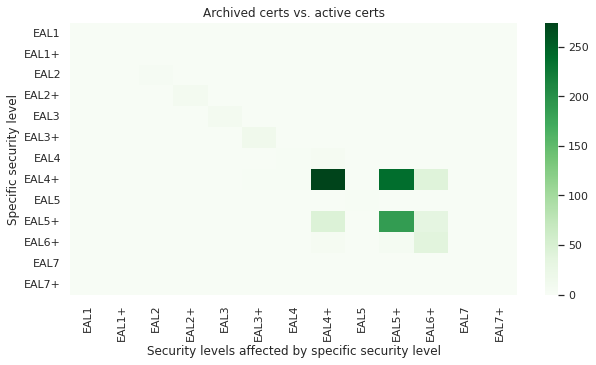

In [25]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 20})
heatmap_result = []


for security_level, counter in result.items():
    security_level_list = []
    for security_level_key in eals:
        security_level_list.append(counter.get(security_level_key, 0))
    
    heatmap_result.append(security_level_list)
    
sns.set(style="whitegrid")
ax = sns.heatmap(heatmap_result, xticklabels=eals, yticklabels=eals,cmap="Greens").set_title("Archived certs vs. active certs")
plt.ylabel("Specific security level")
plt.xlabel("Security levels affected by specific security level")

### Basic Analysis of most common category

In [26]:
cards_df = df[df["category"] == "ICs, Smart Cards and Smart Card-Related Devices and Systems"]
print(f"There are total {cards_df.shape[0]} rows ICs, Smart Cards and Smart Card-Related Devices and Systems category.")

There are total 1488 rows ICs, Smart Cards and Smart Card-Related Devices and Systems category.


#### How many certificates are active/archived

In [27]:
total_archived_certs = sum(cards_df["status"] == "archived")
total_active_certs = sum(cards_df["status"] == "active")

print(f"There are total {total_archived_certs} archived records among smart-cards")
print(f"There are total {total_active_certs} active records among smart-cards")

There are total 924 archived records among smart-cards
There are total 564 active records among smart-cards


#### Which manufacturer is the most common in this category?

In [28]:
most_common_smart_card_manufacturer = cards_df["manufacturer"].value_counts().index[0]
print(f"The most common manufacturer in smart cards category is: {most_common_smart_card_manufacturer}")

The most common manufacturer in smart cards category is: Infineon Technologies AG


#### Analysis of security levels of smart-cards

In [29]:
# The most common security level among smart-cards
most_common_sec_level = cards_df["highest_security_level"].value_counts().index[0]
sec_level_amount = cards_df["highest_security_level"].value_counts()[0]

print(f"Most common security level among smart-cards is {most_common_sec_level} with {sec_level_amount} occurences.")

Most common security level among smart-cards is EAL5+ with 671 occurences.


In [30]:
# The lowest common security level achieved in dataset
security_level_occurences = cards_df["highest_security_level"].value_counts()
filtered_sec_levels = [sec_level for sec_level, count in security_level_occurences.items() if count > 0]
level_numbers = {x: y for x, y in zip(eals, range(len(eals)))}

lowest_smart_card_security_level = None
lowest_security_level_int = None

for sec_level in filtered_sec_levels:
    if lowest_security_level_int is None:
        lowest_security_level_int = level_numbers[sec_level]
        lowest_smart_card_security_level = sec_level
    
    if level_numbers[sec_level] < lowest_security_level_int:
        lowest_security_level_int = level_numbers[sec_level]
        lowest_smart_card_security_level = sec_level
        
print(f"Lowest security level among smart cards in dataset: {lowest_smart_card_security_level}")

Lowest security level among smart cards in dataset: EAL1+


In [31]:
# The highest common security level in smart-card dataset
highest_smart_card_security_level = None
highest_security_level_int = None

for sec_level in filtered_sec_levels:
    if highest_security_level_int is None:
        highest_security_level_int = level_numbers[sec_level]
        highest_smart_card_security_level = sec_level
    
    if level_numbers[sec_level] > highest_security_level_int:
        highest_security_level_int = level_numbers[sec_level]
        highest_smart_card_security_level = sec_level
        
print(f"Highest security level among smart cards in dataset: {highest_smart_card_security_level}")

Highest security level among smart cards in dataset: EAL7


#### View data with lowest security level (EAL1+)

In [32]:
eal1_plus_df = cards_df[cards_df["highest_security_level"] == "EAL1+"]
eal1_plus_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
be0806db6fd6bbe8,NaN,ATMEL AT90SC6464C Integrated circuit (referenc...,archived,"ICs, Smart Cards and Smart Card-Related Device...",ATMEL Smart Card ICs,FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+
1a95d138ccc7814a,Rapport de certification 2001/16,CT2000 embedded Component (reference ST16RFHD5...,archived,"ICs, Smart Cards and Smart Card-Related Device...",ASK,FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+
35ac4cfd1f62df75,NaN,M/Chip Select v2.0.5.2 Application,archived,"ICs, Smart Cards and Smart Card-Related Device...",Mondex International Ltd,FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+
7c062b969e50e2af,Rapport de certification 2001/20,MODEUS electronic purse : MODEUS carrier card ...,archived,"ICs, Smart Cards and Smart Card-Related Device...","ASK, CP8, STMicroelectronics",FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+
f66157c81ab85729,Rapport de certification 2001/03,Oberthur B0' application v1.0.1 and GemClub v1...,archived,"ICs, Smart Cards and Smart Card-Related Device...","Oberthur Card Systems, Gemplus, Trusted Logic",FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+


In [33]:
eal1_plus_df["scheme"].value_counts()

FR    14
AU     0
MY     0
UK     0
TR     0
SG     0
SE     0
NO     0
NL     0
KR     0
CA     0
JP     0
IT     0
IN     0
ES     0
DE     0
US     0
Name: scheme, dtype: int64

#### View data with highest security level (EAL7)

In [34]:
eal7_df = cards_df[cards_df["highest_security_level"] == highest_smart_card_security_level]
eal7_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
8ee7145a1b48b578,ANSSI-CC-2020/33,MultiApp V4 JavaCard Virtual Machine,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto,FR,[EAL7],2020-05-28,2025-05-28,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
d08b5ddedd34448d,ANSSI-CC-2018/50,IDMotion V2 Multos Virtual Machine OS Multos V...,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto / Trusted Labs,FR,[EAL7],2018-12-14,2023-12-14,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
ff45605151ec4eb1,ANSSI-CC-2013/40,Virtual Machine of Multos M3 G230M mask with A...,archived,"ICs, Smart Cards and Smart Card-Related Device...",Multos international / Trusted Labs,FR,[EAL7],2013-07-04,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
9231adbf747903df,ANSSI-CC-2013/12,Memory Management Unit des microcontrôleurs SA...,archived,"ICs, Smart Cards and Smart Card-Related Device...","Samsung Electronics Co., Ltd. / Trusted Labs",FR,[EAL7],2013-03-29,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
890f788a91fc2fa1,ANSSI-CC-2013/11,Virtual Machine of ID Motion V1 G231 mask with...,archived,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto / Trusted Labs,FR,[EAL7],2013-03-29,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7


In [39]:
eal7_df["scheme"].value_counts()

FR    6
US    0
JP    0
CA    0
DE    0
ES    0
IN    0
IT    0
KR    0
UK    0
MY    0
NL    0
NO    0
SE    0
SG    0
TR    0
AU    0
Name: scheme, dtype: int64

In [35]:
eal7_df[eal7_df["status"] == "active"]

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
8ee7145a1b48b578,ANSSI-CC-2020/33,MultiApp V4 JavaCard Virtual Machine,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto,FR,[EAL7],2020-05-28,2025-05-28,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
d08b5ddedd34448d,ANSSI-CC-2018/50,IDMotion V2 Multos Virtual Machine OS Multos V...,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto / Trusted Labs,FR,[EAL7],2018-12-14,2023-12-14,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7


#### BSI certs in smart cards dataset

In [36]:
bsi_smart_cards_df = cards_df[cards_df["is_bsi_cert"]]

print(f"There is total of {bsi_smart_cards_df.shape[0]} BSI records among smart cards")

There is total of 487 BSI records among smart cards


#### Most common security levels among BSI smart card records

In [37]:
bsi_smart_cards_df["highest_security_level"].value_counts()

EAL4+    198
EAL5+    185
EAL6+     70
EAL3+     14
EAL3      11
EAL4       8
EAL1       0
EAL1+      0
EAL2       0
EAL2+      0
EAL5       0
EAL7       0
EAL7+      0
Name: highest_security_level, dtype: int64

#### ANSSI certs in smart cards dataset


In [38]:
anssi_smart_cards_df = cards_df[cards_df["is_anssi_cert"]]

print(f"There is total of {anssi_smart_cards_df.shape[0]} records ANSSI among smart cards")

There is total of 595 records ANSSI among smart cards


#### Most common security levels among ANSSI smart card records 

In [39]:
anssi_smart_cards_df["highest_security_level"].value_counts()

EAL5+    366
EAL4+    183
EAL6+     29
EAL5       6
EAL7       6
EAL3+      3
EAL4       2
EAL1       0
EAL1+      0
EAL2       0
EAL2+      0
EAL3       0
EAL7+      0
Name: highest_security_level, dtype: int64

#### Smarts cards which expires next year


In [40]:
next_year = datetime.datetime.now().year + 1

def is_expiring_next_year(series_datetime):
    return series_datetime.year == next_year


cards_next_year_expires_df = cards_df[cards_df["not_valid_after"].apply(is_expiring_next_year)]
cards_next_year_expires_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
503a0d9db4445cbc,BTBD-03-01-FR-01,Udea SSR_Core v1.0,active,"ICs, Smart Cards and Smart Card-Related Device...",UDEA ELEKTRONİK SAN. TİC. A.Ş,TR,"[ALC_DVS.2, EAL4+]",2020-02-11,2023-02-11,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL4+
a269f33d8469d45f,NaN,NXP Secure Smart Card Controller P60x080/052/0...,active,"ICs, Smart Cards and Smart Card-Related Device...","NXP Semiconductors Germany GmbH, Business Unit...",NL,"[ALC_FLR.1, ASE_TSS.2, EAL6+]",2019-07-30,2023-02-21,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL6+
ed10036ddfbda912,NaN,IDeal Pass v2.3-n JC with Privacy Protection (...,active,"ICs, Smart Cards and Smart Card-Related Device...",Idemia,NL,"[ADV_FSP.5, ADV_INT.2, ADV_TDS.4, ALC_CMC.5, A...",2019-02-18,2023-06-26,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL4+
625b243397001f01,NaN,IDeal Pass v2.3-n JC with Privacy Protection (...,active,"ICs, Smart Cards and Smart Card-Related Device...",Idemia,NL,"[ALC_DVS.2, AVA_VAN.5, EAL5+]",2019-02-18,2023-06-26,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL5+
6dde54b8c6d592ef,BSI-DSZ-CC-1100-2018,Infineon Technologies AG OPTIGA™ Trusted Platf...,active,"ICs, Smart Cards and Smart Card-Related Device...",Infineon Technologies AG,DE,"[ALC_FLR.1, AVA_VAN.4, EAL4+]",2018-12-18,2023-12-18,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-1086-2018},"{BSI-DSZ-CC-1086-2018, BSI-DSZ-CC-0965-2015, B...",True,False,EAL4+


### Which schemes are directly affecting certs with other schemes

In [41]:
df["scheme"].value_counts()

US    884
FR    859
DE    854
JP    522
CA    431
NL    153
ES    147
KR    130
UK    121
AU    101
NO    100
SE     98
MY     66
TR     66
IT     60
IN     16
SG      8
Name: scheme, dtype: int64

In [42]:
scheme_df = df[df["directly_affecting"].notna()]
print(f"Total of {scheme_df.shape[0]} certs are directly affecting other certs.")

Total of 646 certs are directly affecting other certs.


In [43]:
def get_scheme_from_cert_id(cert_id: str) -> str:
    scheme_list = df[df["cert_id"] == cert_id]["scheme"].tolist()
    
    if not scheme_list:
        return None 
    
    
    return df[df["cert_id"] == cert_id]["scheme"].tolist()[0]

In [44]:
CC_SCHEMES = ["US", "FR", "DE", "JP", "CA", "NL", "ES", "KR", "UK", "AU", "NO", "SE", "MY", "TR", "IT", "IN", "SG"]
result = {}


for scheme in CC_SCHEMES:
    counter = collections.Counter()
    scheme_affecting_series = scheme_df[scheme_df["scheme"] == scheme]["directly_affecting"]
    
    for affecting_set in scheme_affecting_series:
        tmp_dict = {}
        
        for cert_id in affecting_set:
            current_scheme = get_scheme_from_cert_id(cert_id)
            tmp_dict[current_scheme] = tmp_dict.get(current_scheme, 0) + 1
            
        counter.update(tmp_dict)
    
    result[scheme] = counter    

print(result)

{'US': Counter(), 'FR': Counter({'FR': 57, 'DE': 56, None: 25, 'KR': 17}), 'DE': Counter({'DE': 723, None: 134, 'FR': 22, 'KR': 14, 'ES': 13, 'NL': 9, 'TR': 7, 'US': 2}), 'JP': Counter({'DE': 2}), 'CA': Counter(), 'NL': Counter({'KR': 1, None: 1}), 'ES': Counter({'DE': 1}), 'KR': Counter({'KR': 3, None: 3, 'DE': 1}), 'UK': Counter(), 'AU': Counter(), 'NO': Counter(), 'SE': Counter(), 'MY': Counter(), 'TR': Counter(), 'IT': Counter(), 'IN': Counter(), 'SG': Counter()}


US Counter()
FR Counter({'FR': 57, 'DE': 56, None: 25, 'KR': 17})
DE Counter({'DE': 723, None: 134, 'FR': 22, 'KR': 14, 'ES': 13, 'NL': 9, 'TR': 7, 'US': 2})
JP Counter({'DE': 2})
CA Counter()
NL Counter({'KR': 1, None: 1})
ES Counter({'DE': 1})
KR Counter({'KR': 3, None: 3, 'DE': 1})
UK Counter()
AU Counter()
NO Counter()
SE Counter()
MY Counter()
TR Counter()
IT Counter()
IN Counter()
SG Counter()
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 57, 56, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 22, 723, 0, 0, 9, 13, 14, 0, 0, 0, 0, 0, 7, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0

Text(0.5, 21.5, 'Schemes affected by specific scheme')

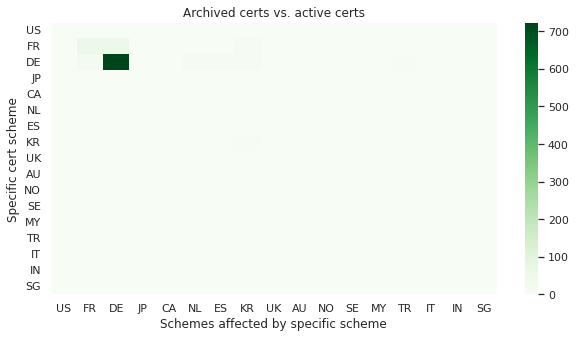

In [45]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 20})
heatmap_result = []


for scheme, counter in result.items():
    print(scheme, counter)
    scheme_list = []
    for scheme_key in CC_SCHEMES:
        scheme_list.append(counter.get(scheme_key, 0))
    
    heatmap_result.append(scheme_list)
    
print(heatmap_result)
sns.set(style="whitegrid")
ax = sns.heatmap(heatmap_result, xticklabels=CC_SCHEMES, yticklabels=CC_SCHEMES,cmap="Greens").set_title("Archived certs vs. active certs")
plt.ylabel("Specific cert scheme")
plt.xlabel("Schemes affected by specific scheme")

#### Dependencies among scheme


In [46]:
def return_unique_years_in_dataset():    
    unique_years = set()

    for timestamp_record in scheme_df["not_valid_before"]:
        unique_years.add(timestamp_record.year)
        
    return unique_years

In [47]:
CC_SCHEMES = ["US", "FR", "DE", "JP", "CA", "NL", "ES", "KR", "UK", "AU", "NO", "SE", "MY", "TR", "IT", "IN", "SG"]

def discover_scheme_dependiencies_in_dataset(dataset):
    result = {}

    for scheme in CC_SCHEMES:
        counter = collections.Counter()
        scheme_affecting_series = dataset[dataset["scheme"] == scheme]["directly_affecting"]

        for affecting_set in scheme_affecting_series:
            tmp_dict = {}

            for cert_id in affecting_set:
                current_scheme = get_scheme_from_cert_id(cert_id)
                tmp_dict[current_scheme] = tmp_dict.get(current_scheme, 0) + 1

            counter.update(tmp_dict)

        result[scheme] = counter

    return result

discover_scheme_dependiencies_in_dataset(scheme_df)

{'US': Counter(),
 'FR': Counter({'DE': 56, None: 25, 'FR': 57, 'KR': 17}),
 'DE': Counter({None: 134,
          'DE': 723,
          'FR': 22,
          'NL': 9,
          'KR': 14,
          'US': 2,
          'ES': 13,
          'TR': 7}),
 'JP': Counter({'DE': 2}),
 'CA': Counter(),
 'NL': Counter({'KR': 1, None: 1}),
 'ES': Counter({'DE': 1}),
 'KR': Counter({'KR': 3, None: 3, 'DE': 1}),
 'UK': Counter(),
 'AU': Counter(),
 'NO': Counter(),
 'SE': Counter(),
 'MY': Counter(),
 'TR': Counter(),
 'IT': Counter(),
 'IN': Counter(),
 'SG': Counter()}

In [48]:
CC_SCHEMES = ["US", "FR", "DE", "JP", "CA", "NL", "ES", "KR", "UK", "AU", "NO", "SE", "MY", "TR", "IT", "IN", "SG"]

def discover_scheme_dependiencies_in_dataset(year: int):
    result = {}

    for scheme in CC_SCHEMES:
        counter = collections.Counter()
        current_scheme_df = scheme_df[scheme_df["scheme"] == scheme]  # ["directly_affecting"]
        
        for index, row in current_scheme_df.iterrows():
            if row["not_valid_before"].year != year:
                continue
            
            tmp_dict = {}
            for cert_id in row["directly_affecting"]:
                current_scheme = get_scheme_from_cert_id(cert_id)
                tmp_dict[current_scheme] = tmp_dict.get(current_scheme, 0) + 1

            counter.update(tmp_dict)

        result[scheme] = counter

    return result

In [104]:
UNIQUE_YEARS = return_unique_years_in_dataset()
year_result = {}

for year in UNIQUE_YEARS:
    scheme_year_df = scheme_df[scheme_df["not_valid_before"] == year]
    year_result[year] = discover_scheme_dependiencies_in_dataset(year)

print(year_result)

{2016: {'US': Counter(), 'FR': Counter({'DE': 28}), 'DE': Counter({'DE': 28, 'NL': 6, None: 3}), 'JP': Counter(), 'CA': Counter(), 'NL': Counter({'KR': 1, None: 1}), 'ES': Counter(), 'KR': Counter(), 'UK': Counter(), 'AU': Counter(), 'NO': Counter(), 'SE': Counter(), 'MY': Counter(), 'TR': Counter(), 'IT': Counter(), 'IN': Counter(), 'SG': Counter()}, 2017: {'US': Counter(), 'FR': Counter(), 'DE': Counter({'DE': 44, None: 9, 'NL': 1, 'FR': 1}), 'JP': Counter(), 'CA': Counter(), 'NL': Counter(), 'ES': Counter(), 'KR': Counter(), 'UK': Counter(), 'AU': Counter(), 'NO': Counter(), 'SE': Counter(), 'MY': Counter(), 'TR': Counter(), 'IT': Counter(), 'IN': Counter(), 'SG': Counter()}, 2018: {'US': Counter(), 'FR': Counter({'DE': 1}), 'DE': Counter({'DE': 46, None: 11, 'FR': 7}), 'JP': Counter(), 'CA': Counter(), 'NL': Counter(), 'ES': Counter(), 'KR': Counter(), 'UK': Counter(), 'AU': Counter(), 'NO': Counter(), 'SE': Counter(), 'MY': Counter(), 'TR': Counter(), 'IT': Counter(), 'IN': Counte

In [49]:
# Tasks
# 1) BSI - referencing ANSSI, vica versa - Done (= without graph)
# 2) Certs referencing each other - Done
# 3) Categories references - done 
# 4) Create graphs for these kind of dependencies in real time

In [ ]:
CC_SCHEMES = ["US", "FR", "DE", "JP", "CA", "NL", "ES", "KR", "UK", "AU", "NO", "SE", "MY", "TR", "IT", "IN", "SG"]

def discover_scheme_dependiencies_in_dataset(dataset):
    result = {}

    for scheme in CC_SCHEMES:
        counter = collections.Counter()
        scheme_affecting_series = dataset[dataset["scheme"] == scheme]["directly_affecting"]

        for affecting_set in scheme_affecting_series:
            tmp_dict = {}

            for cert_id in affecting_set:
                current_scheme = get_scheme_from_cert_id(cert_id)
                tmp_dict[current_scheme] = tmp_dict.get(current_scheme, 0) + 1

            counter.update(tmp_dict)

        result[scheme] = counter

    return result

discover_scheme_dependiencies_in_dataset(scheme_df)


In [75]:
def get_category_from_cert_id(cert_id):
    category_list = df[df["cert_id"] == cert_id]["category"].tolist()
    
    if not category_list:
        return None
    
    return df[df["cert_id"] == cert_id]["category"].tolist()[0]

ALL_CATEGORIES = df["category"].unique()

result = {}
category_df = df.copy()

for category in ALL_CATEGORIES:
    counter = collections.Counter()
    category_affecting_series = category_df[category_df["category"] == category]["directly_affecting"]
    
    if category_affecting_series is np.nan:
        continue
    
    for affecting_set in category_affecting_series:
        
        if affecting_set is np.nan:
            continue

        tmp_dict = {}
        
        for cert_id in affecting_set:
            current_category = get_category_from_cert_id(cert_id)
            tmp_dict[current_category] = tmp_dict.get(current_category, 0) + 1
        
        counter.update(tmp_dict)
    
    result[category] = counter

result

{'Access Control Devices and Systems': Counter({'Access Control Devices and Systems': 2}),
 'Boundary Protection Devices and Systems': Counter({None: 2,
          'Boundary Protection Devices and Systems': 7}),
 'Data Protection': Counter(),
 'Databases': Counter({'Databases': 8, 'Operating Systems': 2}),
 'Detection Devices and Systems': Counter(),
 'ICs, Smart Cards and Smart Card-Related Devices and Systems': Counter({None: 134,
          'ICs, Smart Cards and Smart Card-Related Devices and Systems': 699,
          'Other Devices and Systems': 4,
          'Trusted Computing': 1,
          'Products for Digital Signatures': 8,
          'Databases': 1}),
 'Key Management Systems': Counter({'Key Management Systems': 2, None: 1}),
 'Mobility': Counter(),
 'Multi-Function Devices': Counter(),
 'Network and Network-Related Devices and Systems': Counter({'Network and Network-Related Devices and Systems': 6,
          'Other Devices and Systems': 1,
          'Boundary Protection Devices 

In [ ]:
# Zase nejaka heatmapa by z toho sla
